In [1]:
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
%matplotlib inline

# 1. EDA

## 1.1 Импорт и предобработка

Импортируем датасет, смотрим на колонки

In [2]:
df = pd.read_csv('data_for_test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9827 entries, 0 to 9826
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   time_start_local  9827 non-null   object
 1   time_end_local    9827 non-null   object
 2   time_offset       9827 non-null   int64 
 3   steps             9827 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 307.2+ KB


Пропущенные значения отсутствуют. Время сразу переводим в datetime формат и приводим к UTC в соответствии с time_offset

In [3]:
for col in ['time_start_local', 'time_end_local']:
    df[col] = pd.to_datetime(df[col])
    df[col] = df.apply(lambda x: x[col] - pd.Timedelta(seconds=x.time_offset), axis=1)

## 1.2 Дубликаты

Проверяем наличие дублирующихся записей

In [4]:
df[df.duplicated()]

,time_start_local,time_end_local,time_offset,steps
1,2022-03-19 00:21:58,2022-03-19 00:22:00,3600,2
4,2022-03-19 03:52:55,2022-03-19 03:52:50,3600,6
14,2022-03-19 11:18:55,2022-03-19 11:28:14,3600,19
16,2022-03-19 11:28:14,2022-03-19 11:18:55,3600,19
22,2022-03-19 11:53:41,2022-03-19 11:54:20,3600,6
...,...,...,...,...
9819,2022-03-29 19:11:12,2022-03-29 19:11:20,3600,8
9820,2022-03-29 17:00:30,2022-03-29 17:01:09,3600,74
9823,2022-03-29 05:16:19,2022-03-29 05:21:13,3600,42
9824,2022-03-29 17:01:09,2022-03-29 17:09:40,3600,245


Дублируются почти 20% записей. Требуется дополнительный анализ их возникновения, возможны варианты:
- ошибка импорта/выгрузки из БД,
- проблема в работе приложения на конкретной модели телефона/версии ОС,
- особенность работы конкретной модели треккера.

В последнем случае можно предположить, что треккер передает данные за определенный период частями, т.е. показания дублирующих записей нужно сложить. Предположение так же следует проверить у пользователей аналогичных устройств, однако подозрительно что суммарные показания передаются равными частями. В данном исследовании будем считать данные записи ошибочными, и удалим их из датасета 

In [5]:
df.drop_duplicates(inplace=True)

## 1.3 Интервалы передачи данных

Посмотрим на распределение интервалов передачи данных

In [6]:
df['time_diff'] = (df.time_end_local - df.time_start_local).apply(lambda x: x.total_seconds())

<AxesSubplot: xlabel='time_diff', ylabel='Count'>

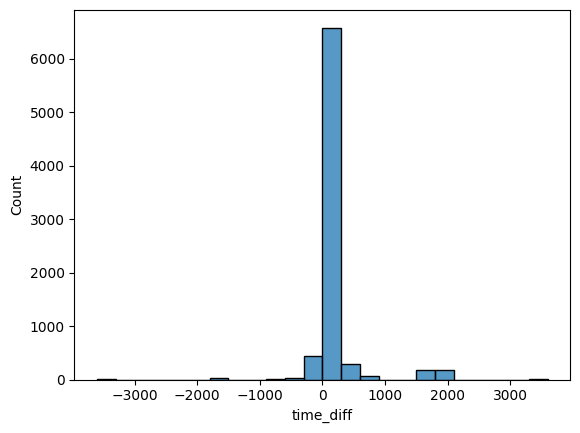

In [7]:
sns.histplot(data=df, x='time_diff', binwidth=300)

In [8]:
df.time_diff.describe()

count    7827.000000
mean      124.760189
std       437.972972
min     -3600.000000
25%         2.000000
50%         3.000000
75%        54.000000
max      3600.000000
Name: time_diff, dtype: float64

In [9]:
df[df.time_diff>1000].time_diff.value_counts()

1800.0    178
1790.0    178
3600.0     19
1699.0      1
1780.0      1
1793.0      1
1020.0      1
1796.0      1
Name: time_diff, dtype: int64

Чуть более 75% интервалов не превышают 1 минуты. Присутствуют получасовые и часовые интервалы, вероятно в треккере/приложении имеется настройка частоты синхронизации, либо применялась аггрегация при выгрузке. Отмечаем наличие отрицательных значений, появление которых так же стоит проверить по указанным в предыдущем разделе предположениям. Перед удалением этих строк попробуем поменять местами начало и конец интервала, и посмотреть нет ли таких же записей в исходном датасете

In [10]:
df[df.time_diff < 0].shape # имеем 500 записей с отрицательным интервалом

(500, 5)

In [11]:
df_tmp = df[['time_start_local', 'time_end_local']]
df['time_start_local'], df['time_end_local'] = df_tmp.min(axis=1), df_tmp.max(axis=1)
df.duplicated(['time_start_local', 'time_end_local', 'time_offset', 'steps']).value_counts() # time_diff не пересчитывался, на него не смотрим

False    7327
True      500
dtype: int64

Видим, что появилось 500 дубликатов, что равно количеству записей с отрицательным интервалом. Удаляем эти записи, и отсортируем датасет по времени начала интервала

In [12]:
df = df[df.time_diff >= 0].sort_values(by='time_start_local').reset_index(drop=True)

## 1.4 Часовые пояса

В датасете присутствует поле сдвига локального времени от UTC. Посмотрим какие уникальные значения оно содержит, корректно ли изменялись часовые пояса.

In [13]:
df.time_offset.unique() # 2 часовых пояса: UTC+1 и UTC+2

array([3600, 7200], dtype=int64)

In [14]:
idx_change_tz = df[df.time_offset != df.time_offset.shift(-1)].index[:-1]

In [15]:
df.loc[(idx_change_tz).append(idx_change_tz+1).unique()].sort_index() # Поля, между которыми происходила смена часового пояса

,time_start_local,time_end_local,time_offset,steps,time_diff
835,2022-03-26 21:36:38,2022-03-26 21:37:09,3600,19,31.0
836,2022-03-27 06:06:15,2022-03-27 06:06:36,7200,32,21.0
863,2022-03-27 21:19:27,2022-03-27 21:19:29,7200,2,2.0
864,2022-03-27 22:35:29,2022-03-27 22:35:32,3600,24,3.0
1551,2022-03-31 21:24:50,2022-03-31 21:25:26,3600,32,36.0
1552,2022-04-01 00:13:46,2022-04-01 00:14:04,7200,24,18.0


(19076.900439814814, 19083.89224537037)

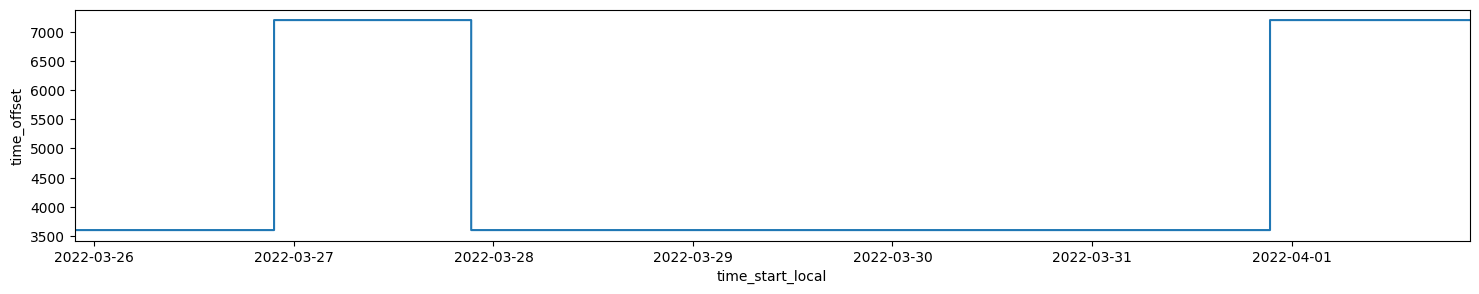

In [16]:
fig, ax = plt.subplots(figsize=(18, 3))
sns.lineplot(data=df, x='time_start_local', y='time_offset', drawstyle='steps-pre')
plt.xlim(df.time_start_local.loc[idx_change_tz[0]] - pd.Timedelta(days=1),
         df.time_start_local.loc[idx_change_tz[-1]] + pd.Timedelta(days=1))

Видим 3 корректные смены часового пояса, без каких либо кратковременных скачков. 

# 2. Алгоритм поиска прогулок

В текущем контексте прогулка - это примерно постоянная ходьба как минимум в течение 5 минут. Идея алгоритма следующая:
1. Определяем максимальную и минимальную скорость прогулочного шага.
2. Для каждой записи считается средняя скорость
3. Отбираем записи, потенциально подходящие нашим условиям. Таких случая два: 
    - если длина интервала меньше 5 минут, конец текущего интервала равен началу следуюшего, средняя скорость интервала в нужном диапазоне
    - если длина интервала больше 5 минут и меньше максимального рассматриваемого интервала (о нем ниже), средняя скорость интервала в нужном диапазоне
4. Группируем найденные интервалы и считаем общее время каждой прогулки.
4. Отфильтровываем интервалы продолжительностью менее 5 минут


Средняя длина человеческого шага - 0.71 м. (данный параметр можно персонализировать если человек указал в приложении свой рост). Медленным шагом считают ходьбу со скоростью 2-3 км/ч, спортивная ходьба начинается с ~7 км/ч. Возьмем (2 - 7)км/ч за интервал скорости прогулочного шага.

По условию функция должна считать интервалы следующими друг за другом, если конец предыдущего равен началу последующего. Однако, во время прогулки человек может делать кратковременные остановки (светофор, эскалатор и тп.). Поэтому введем параметр PAUSE_THRESHOLD, который будет отвечать за допустимую паузу между двумя записями. По умолчанию равен 30 секундам. 

В пункте 1.3 определили, что более 75% записей содержат интервалы длинной до 1 минуты. Однако присутствуют и интервалы в 10, 15, 30, 60 минут. Т.к. минимальный интервал для идентификации ходьбы равен 5 минутам, врядли можно что то сказать о наличии такого промежутка в интервале сильно большем. Количество шагов за час может и соответствовать ходьбе, однако человек мог, например, пробежать этот промежуток за 15 минут, а остальное время отдыхать. Необходимо согласие о максимальной длительности одного интервала, для которой допускается усреднение скорости. За это будет отвечать параметр MAX_WALKING_INTERVAl по умолчанию равный 15 минутам. Все записи длиннее этого значения игнорируются. Объявляем перечисленные переменные:


In [17]:
AVG_STEP = 0.71 # Средняя длина шага, м.
WALKING_SPEED_MIN = 2 # Нижняя граница скорости ходьбы, км/ч
WALKING_SPEED_MAX = 7 # Верхняя граница скорости ходьбы, км/ч
MAX_WALKING_INTERVAl = 900 # Максимальная длительность одного интервала ходьбы, сек.
MIN_WALKING_TIME = 300 # Минимальная длительность интервала ходьбы, сек.
PAUSE_THRESHOLD = 30 # Максимальное время между двумя интервалами, сек.

Удаляем записи, превышающие допустимый порог длины интервала:

In [18]:
df.drop(df[df.time_diff > MAX_WALKING_INTERVAl].index, inplace=True)
df.shape

(7327, 5)

Создадим вспомогательные поля:

    - is_walking_speed показывает, соответствует ли скорость внутри интервала диапазону ходьбы.
    - is_valid_pause показывает, соответствует ли пауза между текущим и предыдщим интервалами максимально допустимой.

In [19]:
df['is_walking_speed'] = (df.steps*AVG_STEP/df.time_diff*3.6).round(decimals=1).between(WALKING_SPEED_MIN, WALKING_SPEED_MAX)
df = df.drop(df[~df.is_walking_speed].index)
df['is_valid_pause'] = (df.time_start_local - df.shift().time_end_local).apply(lambda x: x.total_seconds()) <= PAUSE_THRESHOLD


Находим индексы начала и конца каждого непрерывающегося интервала, и в соответствии с ними нумеруем каждый интервал в поле num_interval

In [20]:
interval_idxs_start = df[(~df.is_valid_pause) & (df.is_valid_pause.shift(-1))].index.to_list()
interval_idxs_end = df[(df.is_valid_pause) & (df.is_valid_pause.shift(-1) == False)].index.to_list()

df['num_interval'] = -1
for i, (start, end) in enumerate(zip(interval_idxs_start, interval_idxs_end)):
    df.loc[start:end, 'num_interval'] = i

Создаем результирующий датафрейм группировкой по полученным интервалам. Фильтруем записи длительностью менее 5 минут

In [21]:
walking_intervals_df = df[df.num_interval >=0].groupby('num_interval').agg({'time_diff': sum, 'time_start_local': min, 'time_end_local': max, 'steps': sum, 'time_offset': min})
walking_intervals_df = walking_intervals_df[walking_intervals_df.time_diff > MIN_WALKING_TIME]
walking_intervals_df.head()

,time_diff,time_start_local,time_end_local,steps,time_offset
num_interval,,,,,
9,381.0,2022-03-21 14:00:16,2022-03-21 14:06:37,674,3600
15,838.0,2022-03-22 13:12:22,2022-03-22 13:26:56,1101,3600
17,945.0,2022-03-22 13:44:47,2022-03-22 14:00:41,1094,3600
18,703.0,2022-03-22 14:10:41,2022-03-22 14:22:40,799,3600
20,729.0,2022-03-22 15:01:42,2022-03-22 15:13:59,830,3600


In [22]:
walking_intervals_df.shape

(95, 5)

Получили 95 подходящих интервала. Создадим поле day для выгрузки в json, приведем поля datetime к строковому виду

In [23]:
walking_intervals_df['day'] = walking_intervals_df.time_start_local.dt.strftime('%Y-%m-%d')
for col in ['time_start_local', 'time_end_local']:
    walking_intervals_df[col] = walking_intervals_df.apply(lambda x: (x[col] + pd.Timedelta(seconds=x.time_offset)), axis=1)
    
walking_intervals_df.drop(['time_diff', 'time_offset'], axis=1, inplace=True)

Создаем словарь с результатами работы и выгружаем в json

In [24]:
result = {day:[] for day in walking_intervals_df.day.unique()}
for row in walking_intervals_df.itertuples():
    result[row.day].append({'start': row.time_start_local.strftime('%Y-%m-%d %H:%M:%S'),
                            'end': row.time_end_local.strftime('%Y-%m-%d %H:%M:%S'),
                            'steps': row.steps})

with open('walkings.json', 'w') as fout:
    json.dump(result, fout)    

Оценим результаты работы алгоритма

In [25]:
walking_intervals_df.steps.describe()

count      95.000000
mean     1219.273684
std      1186.936217
min       288.000000
25%       528.000000
50%       761.000000
75%      1418.500000
max      6282.000000
Name: steps, dtype: float64

<AxesSubplot: xlabel='steps', ylabel='Count'>

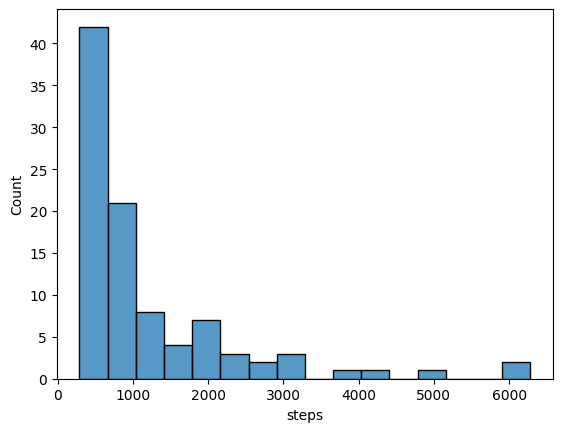

In [26]:
sns.histplot(data=walking_intervals_df, x='steps')

In [27]:
walking_intervals_df[walking_intervals_df.steps>3000]

,time_start_local,time_end_local,steps,day
num_interval,,,,
57,2022-03-26 13:35:41,2022-03-26 14:08:50,3001,2022-03-26
108,2022-03-30 19:50:27,2022-03-30 20:47:25,5085,2022-03-30
109,2022-03-30 21:27:36,2022-03-30 22:14:55,4285,2022-03-30
123,2022-03-31 12:42:59,2022-03-31 13:54:10,6282,2022-03-31
146,2022-04-01 16:38:05,2022-04-01 17:14:48,3079,2022-04-01
180,2022-04-02 13:00:15,2022-04-02 13:23:29,3078,2022-04-02
357,2022-04-17 11:09:13,2022-04-17 11:55:18,3972,2022-04-17
359,2022-04-17 12:10:07,2022-04-17 13:13:09,6207,2022-04-17


Почти 75% выявленных прогулок не превышают 1500 шагов. При этом алгоритм определяет и намного более длительные прогулки. Чувствителен к параметру PAUSE_THRESHOLD на данном датасете. При увеличении параметра c 0 до 30 секунд, количество найденных прогулок возрастает почти на 30%  (75 -> 95). 
Слабой стороной алгоритма является неспособность анализировать большие временные интервалы, представленные одной записью. Это сознательное допущение, т.к. даже если добавить логику обработки таких записей, результат вида: "в период с 13:00 до 14:00 имеется прогулка длительностью не менее 5 минут" малоинформативен. 